# Comparisons

This notebook compares across different methods, running them on the same set of simulations, and comparing the results. 

Time Domain methods that are compared:
- Autocorrelation decay rate
- Hurst exponent
- Detrended Fluctuation Analysis
- Higuchi Fractal Dimension
- Hjorth Complexity
- Lempel Ziv Complexity
- Approximate Entropy
- Permutation Entropy

In addition, the above methods are compared to frequency domain methods:
- Spectral Parameterization

In [1]:
import numpy as np

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.analysis import compute_all_corrs
from apm.plts import plot_dots
from apm.plts.utils import make_axes
from apm.plts.settings import COLORS
from apm.methods import (hurst, dfa, higuchi_fd, hjorth_complexity, lempelziv,
                         app_entropy, perm_entropy, specparam)
from apm.methods.settings import (HURST_PARAMS, DFA_PARAMS, HFD_PARAMS, HJC_PARAMS,
                                  LZ_PARAMS, AP_ENT_PARAMS, PE_ENT_PARAMS)
from apm.sim.settings import FS, SIM_PARAMS_COMB
from apm.sim.params import sampler
from apm.utils import format_corr

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/plts/data.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Define settings
f_range = [1, 50]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : FS, 'f_range' : f_range}

In [6]:
# Settings for running comparisons
RETURN_SIM_PARAMS = True

In [7]:
# Settings for saving figures
SAVE_FIG = False
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '31_comparisons'

## Collect Methods

In [8]:
# Define ranges to sample parameters from
samplers = {'update_comb_exp' : sampler(np.arange(-2.5, 0.1, 0.1)),
            'update_pow' : sampler(np.arange(0, 1.1, 0.1), probs = [0.30] + ([0.07] * 10)),
            'update_freq' : sampler(np.arange(5, 36, 1))}

In [9]:
# Define measures to apply
measures = {
    hurst : HURST_PARAMS, 
    dfa : DFA_PARAMS,
    higuchi_fd : HFD_PARAMS,
    hjorth_complexity : HJC_PARAMS, 
    lempelziv : LZ_PARAMS,
    app_entropy : AP_ENT_PARAMS,
    perm_entropy : PE_ENT_PARAMS,
    specparam : specparam_kwargs,
}

## Run Simulations

In [10]:
N_SIMS = 1000

In [11]:
# Run simulations, comparing specparam exponent to entropy
outputs, all_sim_params = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers, N_SIMS, RETURN_SIM_PARAMS)

In [12]:
# Set a marker in dataframe for yes / no if signal has an oscillation
all_sim_params['has_osc'] = all_sim_params['var_pe'] != 0.

In [13]:
# Compute correlations across all measures
all_corrs = compute_all_corrs(outputs)

In [14]:
# Compute correlations specific to with & without oscillations
all_corrs_osc = compute_all_corrs(outputs, all_sim_params['has_osc'].values)
all_corrs_no_osc = compute_all_corrs(outputs, ~all_sim_params['has_osc'].values)

### Set up plotting things

In [15]:
# Collect colors for each value based on presence of an oscillation
colors = [COLORS['CM'] if osc else COLORS['AP'] for osc in all_sim_params.has_osc]

In [16]:
# Collect together info & plot settings 
dot_kwargs = {'s' : 25, 'c' : colors, 'alpha' : 0.25}

### Fluctuations to Complexity

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


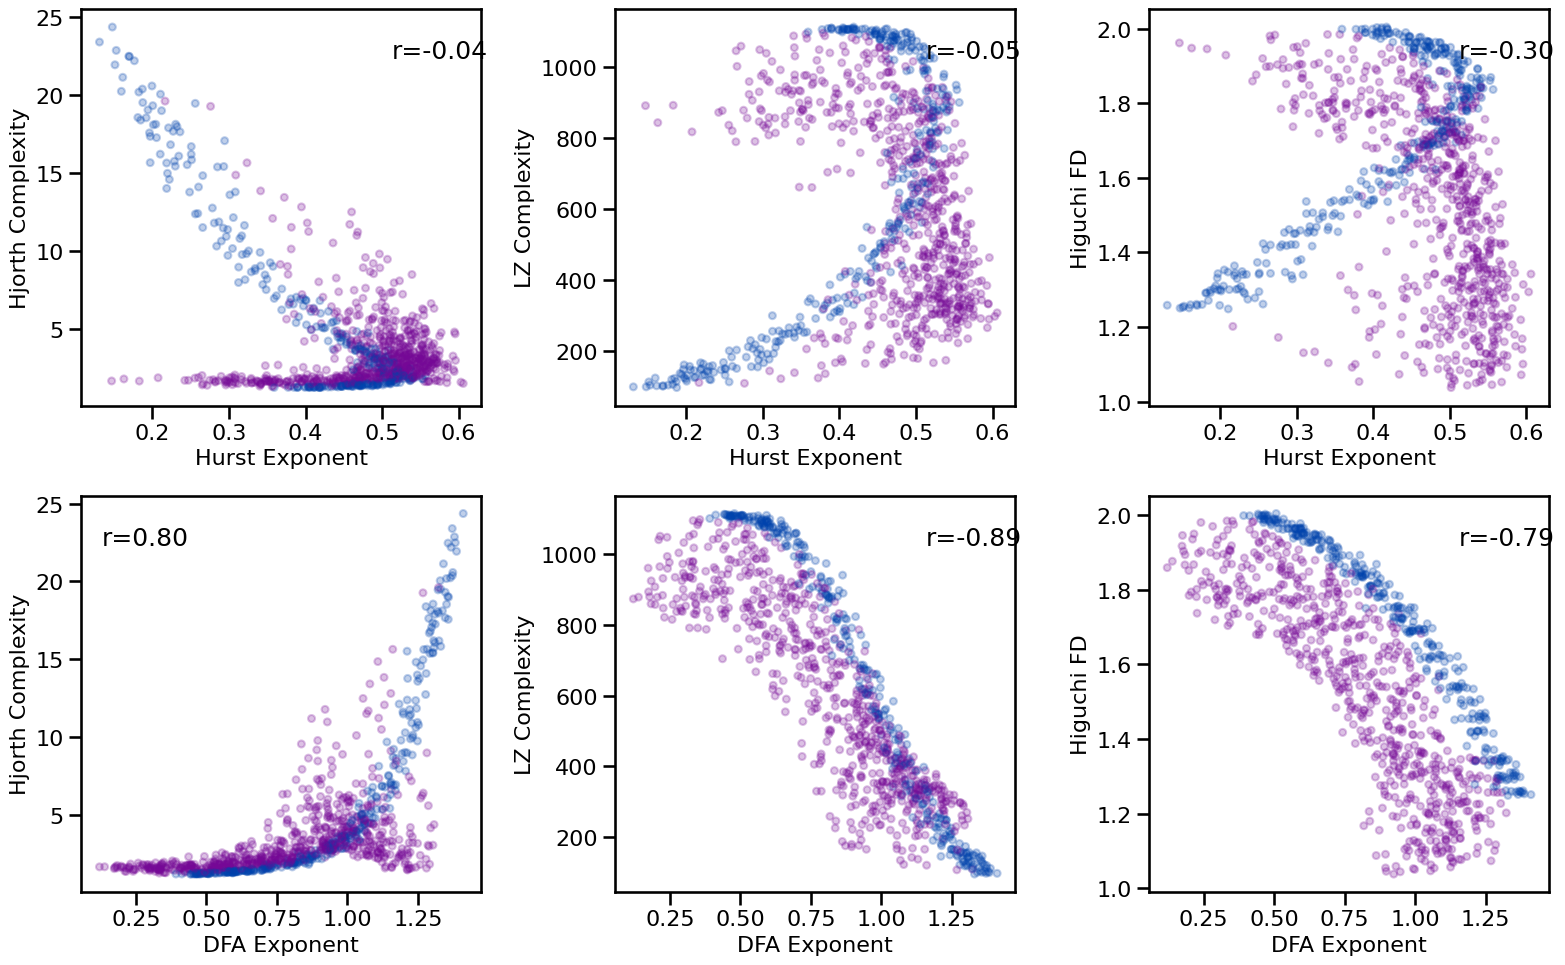

In [17]:
# Plot comparisons
axes = make_axes(2, 3, figsize=[16, 10], wspace=0.4, hspace=0.4)
plot_dots(outputs['hurst'], outputs['hjorth_complexity'], tposition='tr', **dot_kwargs,
          xlabel='Hurst Exponent', ylabel='Hjorth Complexity', ax=axes[0, 0])
plot_dots(outputs['hurst'], outputs['lempelziv'], tposition='tr', **dot_kwargs,
          xlabel='Hurst Exponent', ylabel='LZ Complexity', ax=axes[0, 1])
plot_dots(outputs['hurst'], outputs['higuchi_fd'], tposition='tr', **dot_kwargs,
          xlabel='Hurst Exponent', ylabel='Higuchi FD', ax=axes[0, 2])
plot_dots(outputs['dfa'], outputs['hjorth_complexity'], tposition='tl', **dot_kwargs,
          xlabel='DFA Exponent', ylabel='Hjorth Complexity', ax=axes[1, 0])
plot_dots(outputs['dfa'], outputs['lempelziv'], tposition='tr', **dot_kwargs,
          xlabel='DFA Exponent', ylabel='LZ Complexity', ax=axes[1, 1])
plot_dots(outputs['dfa'], outputs['higuchi_fd'], tposition='tr', **dot_kwargs,
          xlabel='DFA Exponent', ylabel='Higuchi FD', ax=axes[1, 2])
if SAVE_FIG: plt.savefig(FIGPATH / ('fluc_compl_comp' + EXT))

In [18]:
print('Correlations:')
print('  HST & HJO:\t', format_corr(*all_corrs['hurst']['hjorth_complexity']))
print('         AP:\t', format_corr(*all_corrs_no_osc['hurst']['hjorth_complexity']))
print('       COMB:\t', format_corr(*all_corrs_osc['hurst']['hjorth_complexity']))
print('  HST & LZC:\t', format_corr(*all_corrs['hurst']['lempelziv']))
print('  HST & HFD:\t', format_corr(*all_corrs['hurst']['higuchi_fd']))
print('  DFA & HJO:\t', format_corr(*all_corrs['dfa']['hjorth_complexity']))
print('  DFA & LZC:\t', format_corr(*all_corrs['dfa']['lempelziv']))
print('  DFA & HFD:\t', format_corr(*all_corrs['dfa']['higuchi_fd']))

Correlations:
  HST & HJO:	 r=-0.040  CI[-0.114, +0.036],  p=0.206
         AP:	 r=-0.612  CI[-0.704, -0.503],  p=0.000
       COMB:	 r=+0.315  CI[+0.233, +0.391],  p=0.000
  HST & LZC:	 r=-0.045  CI[-0.119, +0.032],  p=0.154
  HST & HFD:	 r=-0.302  CI[-0.362, -0.238],  p=0.000
  DFA & HJO:	 r=+0.800  CI[+0.768, +0.829],  p=0.000
  DFA & LZC:	 r=-0.885  CI[-0.896, -0.873],  p=0.000
  DFA & HFD:	 r=-0.792  CI[-0.805, -0.776],  p=0.000


### Complexity to Entropy

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


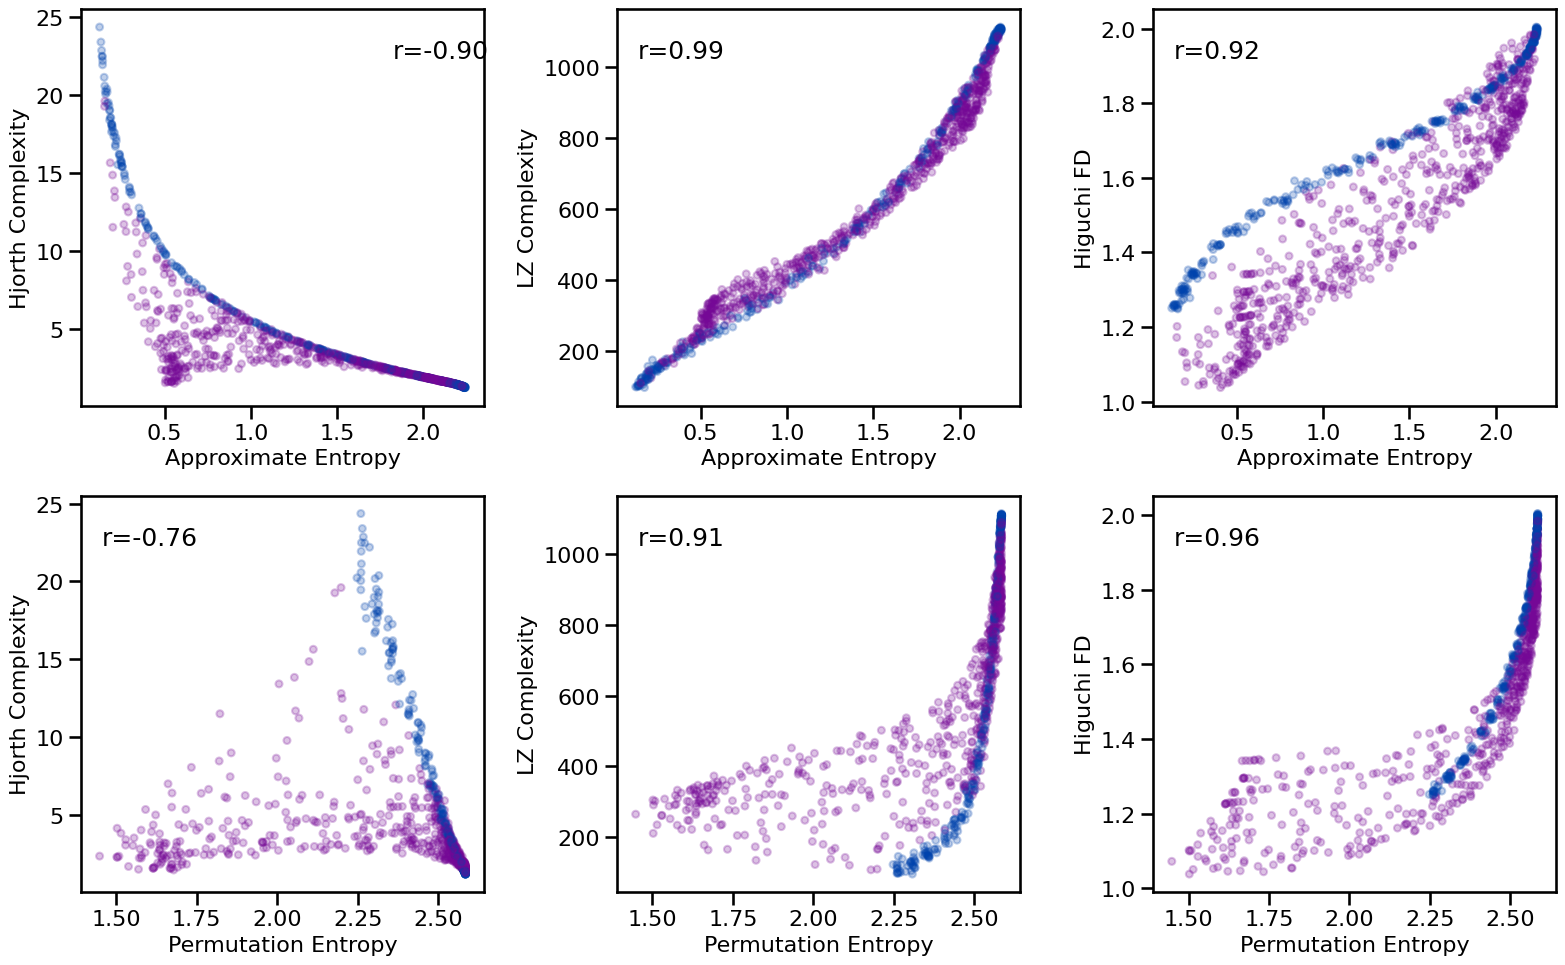

In [19]:
# Plot comparisons
axes = make_axes(2, 3, figsize=[16, 10], wspace=0.4, hspace=0.4)
plot_dots(outputs['app_entropy'], outputs['hjorth_complexity'], tposition='tr', **dot_kwargs,
          xlabel='Approximate Entropy', ylabel='Hjorth Complexity', ax=axes[0, 0])
plot_dots(outputs['app_entropy'], outputs['lempelziv'], tposition='tl', **dot_kwargs,
          xlabel='Approximate Entropy', ylabel='LZ Complexity', ax=axes[0, 1])
plot_dots(outputs['app_entropy'], outputs['higuchi_fd'], tposition='tl', **dot_kwargs,
          xlabel='Approximate Entropy', ylabel='Higuchi FD', ax=axes[0, 2])
plot_dots(outputs['perm_entropy'], outputs['hjorth_complexity'], tposition='tl', **dot_kwargs,
          xlabel='Permutation Entropy', ylabel='Hjorth Complexity', ax=axes[1, 0])
plot_dots(outputs['perm_entropy'], outputs['lempelziv'], tposition='tl', **dot_kwargs,
          xlabel='Permutation Entropy', ylabel='LZ Complexity', ax=axes[1, 1])
plot_dots(outputs['perm_entropy'], outputs['higuchi_fd'], tposition='tl', **dot_kwargs,
          xlabel='Permutation Entropy', ylabel='Higuchi FD', ax=axes[1, 2])
if SAVE_FIG: plt.savefig(FIGPATH / ('compl_info_comp' + EXT))

In [20]:
print('Correlations:')
print('  AEN & HJO:  ', format_corr(*all_corrs['app_entropy']['hjorth_complexity']))
print('  AEN & LZC:  ', format_corr(*all_corrs['app_entropy']['lempelziv']))
print('  AEN & HFD:  ', format_corr(*all_corrs['app_entropy']['higuchi_fd']))
print('  PEN & HJO:  ', format_corr(*all_corrs['perm_entropy']['hjorth_complexity']))
print('  PEN & LZC:  ', format_corr(*all_corrs['perm_entropy']['lempelziv']))
print('  PEN & HFD:  ', format_corr(*all_corrs['perm_entropy']['higuchi_fd']))

Correlations:
  AEN & HJO:   r=-0.896  CI[-0.920, -0.869],  p=0.000
  AEN & LZC:   r=+0.994  CI[+0.992, +0.995],  p=0.000
  AEN & HFD:   r=+0.920  CI[+0.912, +0.927],  p=0.000
  PEN & HJO:   r=-0.763  CI[-0.803, -0.721],  p=0.000
  PEN & LZC:   r=+0.912  CI[+0.899, +0.922],  p=0.000
  PEN & HFD:   r=+0.960  CI[+0.955, +0.964],  p=0.000


### Entropy to Fluctuations

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


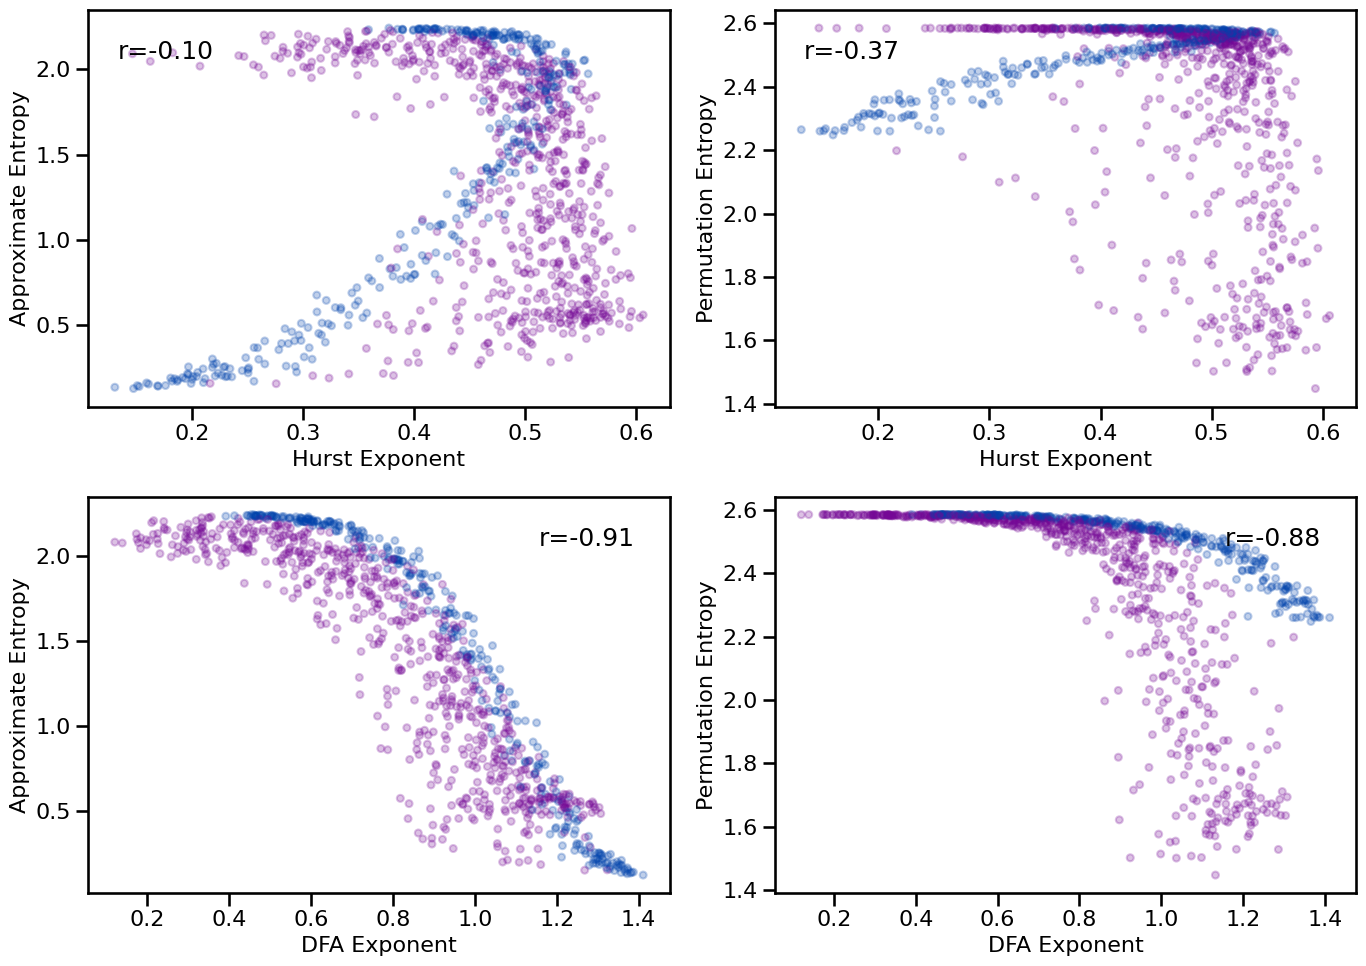

In [21]:
# Plot comparisons
axes = make_axes(2, 2, figsize=[14, 10], wspace=0.4, hspace=0.4)
plot_dots(outputs['hurst'], outputs['app_entropy'], tposition='tl', **dot_kwargs,
          xlabel='Hurst Exponent', ylabel='Approximate Entropy', ax=axes[0, 0])
plot_dots(outputs['hurst'], outputs['perm_entropy'], tposition='tl', **dot_kwargs,
          xlabel='Hurst Exponent', ylabel='Permutation Entropy', ax=axes[0, 1])
plot_dots(outputs['dfa'], outputs['app_entropy'], tposition='tr', **dot_kwargs,
          xlabel='DFA Exponent', ylabel='Approximate Entropy', ax=axes[1, 0])
plot_dots(outputs['dfa'], outputs['perm_entropy'], tposition='tr', **dot_kwargs,
          xlabel='DFA Exponent', ylabel='Permutation Entropy', ax=axes[1, 1])
if SAVE_FIG: plt.savefig(FIGPATH / ('info_fluc_comp' + EXT))

In [22]:
print('Correlations:')
print('  HST & AEN:  ', format_corr(*all_corrs['hurst']['app_entropy']))
print('  HST & PEN:  ', format_corr(*all_corrs['hurst']['perm_entropy']))
print('  DFA & AEN:  ', format_corr(*all_corrs['dfa']['app_entropy']))
print('  DFA & PEN:  ', format_corr(*all_corrs['dfa']['perm_entropy']))

Correlations:
  HST & AEN:   r=-0.104  CI[-0.179, -0.029],  p=0.001
  HST & PEN:   r=-0.374  CI[-0.434, -0.311],  p=0.000
  DFA & AEN:   r=-0.910  CI[-0.919, -0.900],  p=0.000
  DFA & PEN:   r=-0.884  CI[-0.896, -0.870],  p=0.000


## Exponent Comparisons

#### Exponent to Fluctuations

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


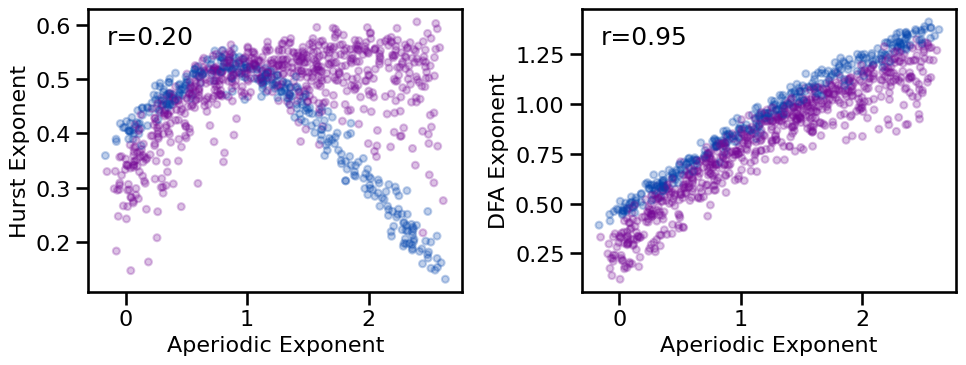

In [23]:
# Plot comparisons
axes = make_axes(1, 2, figsize=(10, 4), wspace=0.35)
plot_dots(outputs['specparam'], outputs['hurst'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hurst Exponent', ax=axes[0])
plot_dots(outputs['specparam'], outputs['dfa'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='DFA Exponent', ax=axes[1])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_fluc_comp' + EXT))

In [24]:
print('Correlations:')
print('  EXP & HST:  ', format_corr(*all_corrs['specparam']['hurst']))
print('  EXP & DFA:  ', format_corr(*all_corrs['specparam']['dfa']))

Correlations:
  EXP & HST:   r=+0.197  CI[+0.124, +0.273],  p=0.000
  EXP & DFA:   r=+0.947  CI[+0.939, +0.955],  p=0.000


#### Exponent to Complexity

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


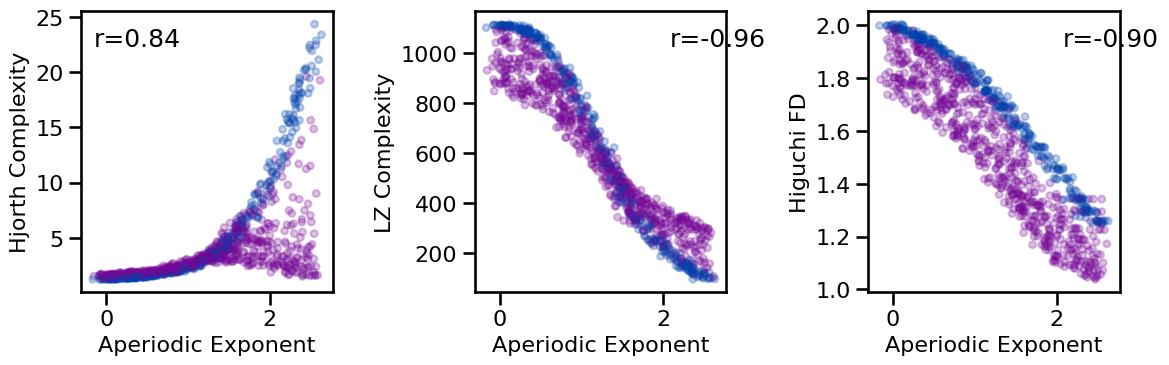

In [30]:
# Plot comparisons
axes = make_axes(1, 3, figsize=[12, 4], wspace=0.35)
plot_dots(outputs['specparam'], outputs['hjorth_complexity'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[0])
plot_dots(outputs['specparam'], outputs['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[1])
plot_dots(outputs['specparam'], outputs['higuchi_fd'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Higuchi FD', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_compl_comp' + EXT))

In [26]:
print('Correlations:')
print('  EXP & HJO:  ', format_corr(*all_corrs['specparam']['hjorth_complexity']))
print('  EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  EXP & HFD:  ', format_corr(*all_corrs['specparam']['higuchi_fd']))

Correlations:
  EXP & HJO:   r=+0.843  CI[+0.810, +0.874],  p=0.000
  EXP & LZC:   r=-0.958  CI[-0.963, -0.951],  p=0.000
  EXP & HFD:   r=-0.901  CI[-0.908, -0.892],  p=0.000


#### Exponent to Entropy

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


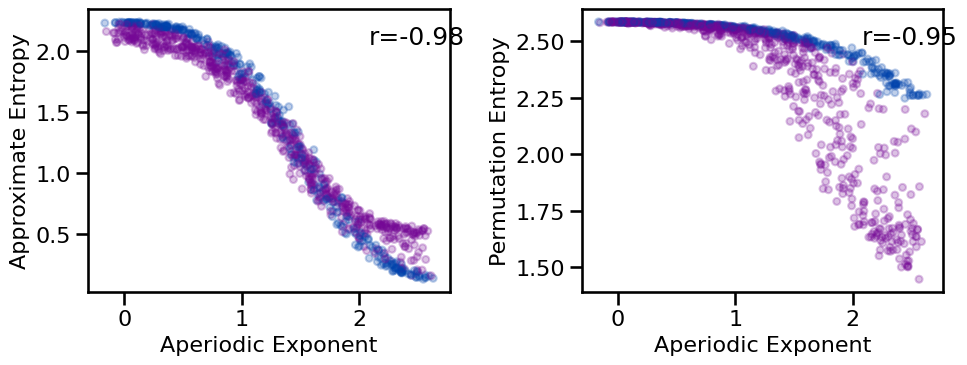

In [31]:
# Plot comparisons
axes = make_axes(1, 2, figsize=[10, 4], wspace=0.35, hspace=0.35)
plot_dots(outputs['specparam'], outputs['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Approximate Entropy', ax=axes[0])
plot_dots(outputs['specparam'], outputs['perm_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Permutation Entropy', ax=axes[1])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_info_comp' + EXT))

In [28]:
print('Correlations:')
print('  EXP & APPR:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  EXP & PERM:  ', format_corr(*all_corrs['specparam']['perm_entropy']))

Correlations:
  EXP & APPR:   r=-0.978  CI[-0.981, -0.974],  p=0.000
  EXP & PERM:   r=-0.954  CI[-0.960, -0.947],  p=0.000


## Conclusions

Comparing between time domain methods, overall we can see that:
- Fluctuation and complexity measures have varying, and generally non-linear, relationships to each other
- There is generally (though not exclusively) a positive correlation between entropy measures and complexity measures
- Entropy is generally negatively correlated to fluctuation measures, though the pattern is non-linear


Comparing time domain methods to exponent, overall we can see that:
- Hurst and DFA exponent generally increase with increasing aperiodic exponent
- Hjorth complexity increases, but lempel-ziv and higuchi fractal dimension decrease, with increasing exponent
- Entropy measures generally decrease with increasing exponent